# Velocity and Acceleration
The idea is to see which peaks are moving in the same direction and speeding at the same time.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy.polynomial import Polynomial
import pandas as pd
import numpy as np

## Load Data
Load a set of tracks from a previous problem

In [2]:
peak_data = pd.read_csv('../0_explore-trackpy/tracks/nearest-velocity-tracks.csv')

In [3]:
frame_data = pd.read_pickle('../peak_data.pkl.gz')
print(f'Loaded data from {len(frame_data)} frames')

Loaded data from 256 frames


## Group Segments Together
Let's find which elements have similar rates of change of $\delta$ at a certain position

In [4]:
target_frame = 215

In [5]:
track_data = []
frame_time = frame_data.loc[target_frame]['time_hr']
for tid, track in peak_data.groupby('particle'):
    # Find if we have frames near the target
    frame = {'track': tid, 'valid': False}
    if np.abs(track['frame'] - target_frame).min() > 1: 
        track_data.append(frame)
        continue
        
    # Fit a spline for \delta(log(t))
    window = 0.2
    track = track.query(f'{frame_time * window} < time_hr < {frame_time / window}')
    f = Polynomial.fit(np.log(track['time_hr']), track['offset'], 5)
    
    # Get the velocity and acceleration
    frame['valid'] = True
    frame['delta_vel'] = f.deriv(1)(np.log(frame_time))
    frame['delta_acc'] = f.deriv(2)(np.log(frame_time))
    track_data.append(frame)
track_data = pd.DataFrame(track_data)
print(f'Frame time: {frame_time:.1f} hr')

Frame time: 125.3 hr


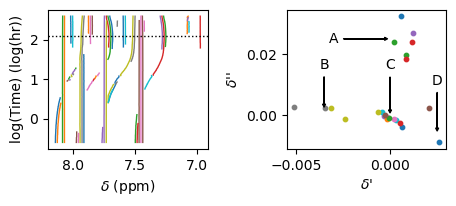

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.))

for i, track in track_data.iterrows():
    axs[1].scatter([track['delta_vel']], [track['delta_acc']], s=10)
    
    group = peak_data.query(f'particle=={i}')
    axs[0].plot(group['offset'], np.log10(group['time_hr']), '-', lw=1.)
    
axs[1].set_xlabel('$\delta$\'')
axs[1].set_ylabel('$\delta$\'\'')

axs[0].set_xlim(axs[0].get_xlim()[::-1])
axs[0].set_xlabel('$\delta$ (ppm)')
axs[0].set_ylabel('log(Time) (log(hr))')

# Put the chosen time
axs[0].plot(axs[0].get_xlim(), np.log10([frame_time] * 2), 'k:', lw=1)

# Annotate the clusters
arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=2, headlength=2)
axs[1].annotate('D', xy=(0.0025, -0.006), xytext=(0.0025, 0.01), arrowprops=arrowprops, ha='center')
axs[1].annotate('C', xy=(0, 0.), xytext=(-0., 0.015), arrowprops=arrowprops, ha='center')
axs[1].annotate('B', xy=(-0.0035, 0.002), xytext=(-0.0035, 0.015), arrowprops=arrowprops, ha='center')
axs[1].annotate('A', xy=(0.0, 0.025), xytext=(-0.003, 0.025), arrowprops=arrowprops, ha='center', va='center')

fig.tight_layout(pad=0.5)
fig.savefig('figures/compare-derivatives.png', dpi=320)

We can see some clusters forming based on the slope and curvature of $\delta$ over time.